In [1]:
import math
from math import exp, sqrt, log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy
import xlsxwriter

from scipy import stats
import pylab
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson

import sqlite3
from sqlite3 import Error
 
""" create a database connection tool to a SQLite database """
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")

2.6.0


In [2]:
#Select Statement to import the SQL Data back into Python:   
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute("SELECT * FROM MACRO_RAW")
macro_sql_data=c.fetchall()
macro_raw_abs = pd.DataFrame(macro_sql_data,columns=['Macro_Variable', 'DATE', 'Value'])
macro_raw_abs = macro_raw_abs.set_index('DATE')
macro_raw_abs_pivot = macro_raw_abs.pivot(columns='Macro_Variable', values=['Value'])
macro_raw_abs_pivot = macro_raw_abs_pivot.droplevel(level=0, axis=1)

c.execute("SELECT * FROM FUTURES_RAW")
futures_sql_data=c.fetchall()
futures_raw = pd.DataFrame(futures_sql_data,columns=['DATE', 'CLOSE', 'Instrument', 'Return'])
futures_raw = futures_raw.set_index('DATE')
futures_raw_close_pivot = futures_raw.pivot(columns='Instrument', values=['CLOSE']) 
futures_raw_close_pivot = futures_raw_close_pivot.droplevel(level=0, axis=1)

futures_raw_return_pivot = futures_raw.pivot(columns='Instrument', values=['Return'])
futures_raw_return_pivot = futures_raw_return_pivot.droplevel(level=0, axis=1)

In [3]:
macro_raw_abs_pivot.describe()

Macro_Variable,CHCPIY_ECI,CHJOB_ECI,CHPMI_ECI,CNCPI_ECI,CNPMIB_ECI,CNURUA_ECI,EUHICY_ECI,EUPMI_ECI,EUUNR_ECI,RUCPIY_ECI,RUPMIM_ECI,RUUNR_ECI,USCPI_ECI,USPMI_ECI,USUNR_ECI
count,121.000000,121.000000,121.000000,121.000000,121.000000,52.000000,121.000000,49.000000,121.000000,121.000000,33.000000,121.000000,121.000000,121.000000,121.000000
mean,-0.089256,2.963636,54.158678,2.089256,50.510744,5.186538,1.217355,52.934694,9.717355,6.338017,48.203030,5.247934,0.176033,54.338843,5.734711
std,0.728560,0.344722,6.577255,0.996561,1.590430,0.317483,1.041448,6.465374,1.719577,3.607336,4.202342,0.528062,0.253977,4.137237,1.953062
min,-1.400000,2.300000,40.700000,-0.500000,35.700000,4.800000,-0.600000,33.400000,7.000000,2.200000,31.300000,4.300000,-0.800000,41.600000,3.500000
25%,-0.600000,2.800000,49.200000,1.500000,50.100000,5.000000,0.400000,47.700000,8.100000,3.800000,47.500000,4.900000,0.000000,51.300000,4.200000
50%,-0.100000,3.100000,53.700000,2.000000,50.500000,5.100000,1.200000,53.700000,9.700000,5.800000,49.100000,5.200000,0.200000,54.400000,5.200000
75%,0.600000,3.200000,58.200000,2.500000,51.200000,5.300000,1.900000,58.000000,11.500000,7.300000,50.900000,5.600000,0.300000,57.600000,6.900000
max,1.500000,3.500000,70.000000,5.400000,53.300000,6.200000,5.000000,63.400000,12.200000,16.900000,51.900000,6.400000,0.900000,63.700000,14.700000


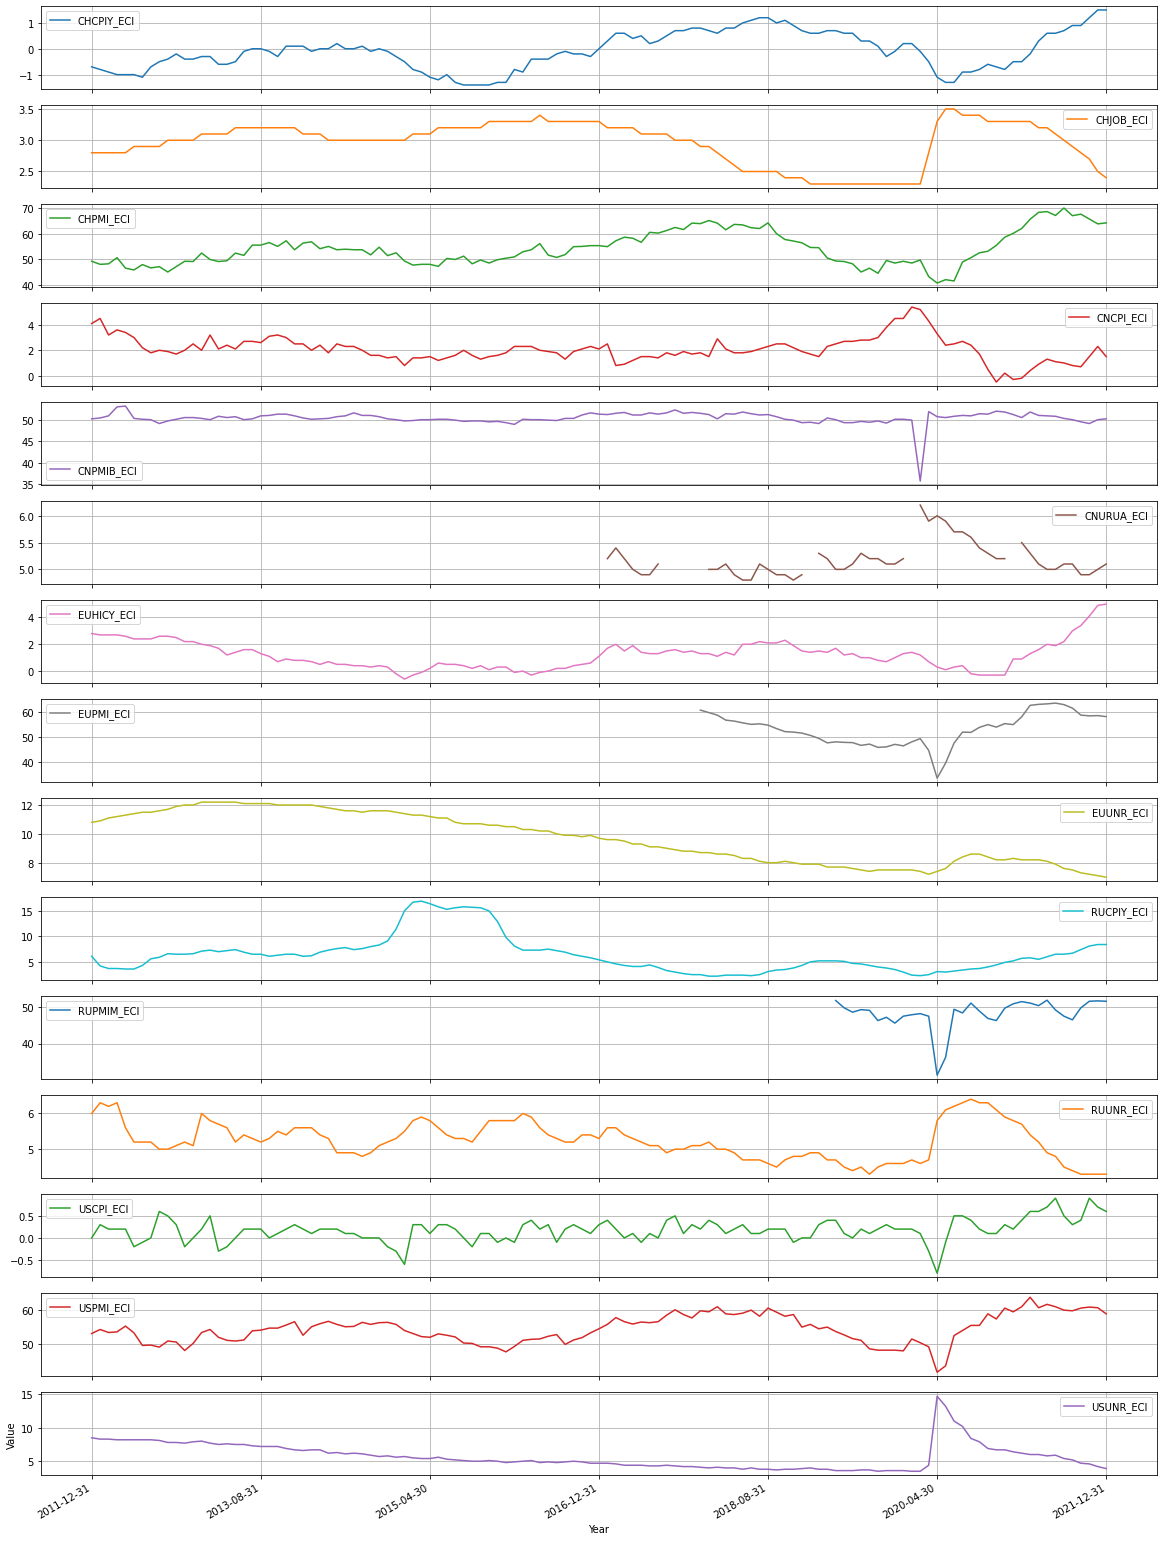

In [4]:
macro_raw_abs_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')
plt.savefig('Grafiken\Makro absolut Line-Charts', dpi=800)

In [5]:
macro_raw_abs_pivot.isna().sum()

Macro_Variable
CHCPIY_ECI     0
CHJOB_ECI      0
CHPMI_ECI      0
CNCPI_ECI      0
CNPMIB_ECI     0
CNURUA_ECI    69
EUHICY_ECI     0
EUPMI_ECI     72
EUUNR_ECI      0
RUCPIY_ECI     0
RUPMIM_ECI    88
RUUNR_ECI      0
USCPI_ECI      0
USPMI_ECI      0
USUNR_ECI      0
dtype: int64

Following Indicators have missing Data and should be removed:
- CNURUA_ECI
- EUPMI_ECI
- RUPMIM_ECI

Once for the SQL DB:

In [6]:
col_to_drop = ['CNURUA_ECI','EUPMI_ECI','RUPMIM_ECI']
macro_clean_abs = macro_raw_abs[macro_raw_abs.Macro_Variable.isin(col_to_drop) == False]
macro_clean_abs

,Macro_Variable,Value
DATE,,
2011-12-31,USUNR_ECI,8.5
2012-01-31,USUNR_ECI,8.3
2012-02-29,USUNR_ECI,8.3
2012-03-31,USUNR_ECI,8.2
2012-04-30,USUNR_ECI,8.2
...,...,...
2021-08-31,RUCPIY_ECI,6.7
2021-09-30,RUCPIY_ECI,7.4
2021-10-31,RUCPIY_ECI,8.1


Once for the Excel-pivot Table:

In [7]:
macro_clean_abs_pivot = macro_raw_abs_pivot.drop(columns=['CNURUA_ECI','EUPMI_ECI','RUPMIM_ECI'], axis=1)
macro_clean_abs_pivot

Macro_Variable,CHCPIY_ECI,CHJOB_ECI,CHPMI_ECI,CNCPI_ECI,CNPMIB_ECI,EUHICY_ECI,EUUNR_ECI,RUCPIY_ECI,RUUNR_ECI,USCPI_ECI,USPMI_ECI,USUNR_ECI
DATE,,,,,,,,,,,,
2011-12-31,-0.7,2.8,49.2,4.1,50.3,2.8,10.8,6.1,6.0,0.0,53.0,8.5
2012-01-31,-0.8,2.8,48.0,4.5,50.5,2.7,10.9,4.2,6.3,0.3,54.2,8.3
2012-02-29,-0.9,2.8,48.2,3.2,51.0,2.7,11.1,3.7,6.2,0.2,53.3,8.3
2012-03-31,-1.0,2.8,50.6,3.6,53.1,2.7,11.2,3.7,6.3,0.2,53.5,8.2
2012-04-30,-1.0,2.8,46.5,3.4,53.3,2.6,11.3,3.6,5.6,0.2,55.2,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.9,2.9,67.0,0.8,50.1,3.0,7.5,6.7,4.4,0.3,59.7,5.2
2021-09-30,0.9,2.8,67.6,0.7,49.6,3.4,7.3,7.4,4.3,0.4,60.5,4.7
2021-10-31,1.2,2.7,65.7,1.5,49.2,4.1,7.2,8.1,4.3,0.9,60.8,4.6


In [8]:
macro_clean_abs_pivot.describe()

Macro_Variable,CHCPIY_ECI,CHJOB_ECI,CHPMI_ECI,CNCPI_ECI,CNPMIB_ECI,EUHICY_ECI,EUUNR_ECI,RUCPIY_ECI,RUUNR_ECI,USCPI_ECI,USPMI_ECI,USUNR_ECI
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,-0.089256,2.963636,54.158678,2.089256,50.510744,1.217355,9.717355,6.338017,5.247934,0.176033,54.338843,5.734711
std,0.728560,0.344722,6.577255,0.996561,1.590430,1.041448,1.719577,3.607336,0.528062,0.253977,4.137237,1.953062
min,-1.400000,2.300000,40.700000,-0.500000,35.700000,-0.600000,7.000000,2.200000,4.300000,-0.800000,41.600000,3.500000
25%,-0.600000,2.800000,49.200000,1.500000,50.100000,0.400000,8.100000,3.800000,4.900000,0.000000,51.300000,4.200000
50%,-0.100000,3.100000,53.700000,2.000000,50.500000,1.200000,9.700000,5.800000,5.200000,0.200000,54.400000,5.200000
75%,0.600000,3.200000,58.200000,2.500000,51.200000,1.900000,11.500000,7.300000,5.600000,0.300000,57.600000,6.900000
max,1.500000,3.500000,70.000000,5.400000,53.300000,5.000000,12.200000,16.900000,6.400000,0.900000,63.700000,14.700000


The Unit for the Macro Indicators are not identical. Therefore we calculate the difference:

In [4]:
#'USUNR_ECI',  US Unemploymet     -> %-rate -> %-diff 
#'USCPI_ECI',  US CPI             -> already in diff %
#'USPMI_ECI',  US PMI             -> index -> log diff
#'EUUNR_ECI',  EU Unemployment    -> %-rate -> %-diff 
#'EUHICY_ECI', EU CPI             -> %-rate -> %-diff 
#'CHJOB_ECI',  CH Unemployment    -> %-rate -> %-diff 
#'CHCPIY_ECI', CH CPI             -> %-rate -> %-diff 
#'CHPMI_ECI',  CH PMI             -> index
#'CNCPI_ECI',  China CPI          -> %-rate -> %-diff 
#'CNPMIB_ECI', China PMI          -> index
#'RUUNR_ECI',  Russia Unempl.     -> %-rate -> %-diff 
#'RUCPIY_ECI', Russia CPI         -> %-rate -> %-diff 

Here we calculate the Difference: 

In [11]:
macro_raw_diff_pivot = pd.DataFrame()
macro_raw_diff_pivot['CHCPIY_DIFF']   = macro_raw_abs_pivot['CHCPIY_ECI']         -   macro_raw_abs_pivot['CHCPIY_ECI'].shift(1)
macro_raw_diff_pivot['CHJOB_DIFF']    = macro_raw_abs_pivot['CHJOB_ECI']          -   macro_raw_abs_pivot['CHJOB_ECI'].shift(1)
macro_raw_diff_pivot['CHPMI_LOG']     = np.log(macro_raw_abs_pivot['CHPMI_ECI'])  -   np.log(macro_raw_abs_pivot['CHPMI_ECI'].shift(1))
macro_raw_diff_pivot['CNCPI_DIFF']    = macro_raw_abs_pivot['CNCPI_ECI']          -   macro_raw_abs_pivot['CNCPI_ECI'].shift(1)
macro_raw_diff_pivot['CNPMIB_LOG']    = np.log(macro_raw_abs_pivot['CNPMIB_ECI']) -   np.log(macro_raw_abs_pivot['CNPMIB_ECI'].shift(1))
macro_raw_diff_pivot['EUHICY_DIFF']   = macro_raw_abs_pivot['EUHICY_ECI']         -   macro_raw_abs_pivot['EUHICY_ECI'].shift(1)
macro_raw_diff_pivot['EUUNR_DIFF']    = macro_raw_abs_pivot['EUUNR_ECI']          -   macro_raw_abs_pivot['EUUNR_ECI'].shift(1)
macro_raw_diff_pivot['RUCPIY_DIFF']   = macro_raw_abs_pivot['RUCPIY_ECI']         -   macro_raw_abs_pivot['RUCPIY_ECI'].shift(1)
macro_raw_diff_pivot['RUUNR_DIFF']    = macro_raw_abs_pivot['RUUNR_ECI']          -   macro_raw_abs_pivot['RUUNR_ECI'].shift(1)
macro_raw_diff_pivot['USPMI_LOG']     = np.log(macro_raw_abs_pivot['USPMI_ECI'])  -   np.log(macro_raw_abs_pivot['USPMI_ECI'].shift(1))
macro_raw_diff_pivot['USUNR_DIFF']    = macro_raw_abs_pivot['USUNR_ECI']          -   macro_raw_abs_pivot['USUNR_ECI'].shift(1)
macro_raw_diff_pivot['USCPI_DIFF']    = macro_raw_abs_pivot['USCPI_ECI']
macro_raw_diff_pivot

,CHCPIY_DIFF,CHJOB_DIFF,CHPMI_LOG,CNCPI_DIFF,CNPMIB_LOG,EUHICY_DIFF,EUUNR_DIFF,RUCPIY_DIFF,RUUNR_DIFF,USPMI_LOG,USUNR_DIFF,USCPI_DIFF
DATE,,,,,,,,,,,,
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2012-01-31,-0.1,0.0,-0.024693,0.4,0.003968,-0.1,0.1,-1.9,0.3,0.022389,-0.2,0.3
2012-02-29,-0.1,0.0,0.004158,-1.3,0.009852,0.0,0.2,-0.5,-0.1,-0.016745,0.0,0.2
2012-03-31,-0.1,0.0,0.048593,0.4,0.040351,0.0,0.1,0.0,0.1,0.003745,-0.1,0.2
2012-04-30,0.0,0.0,-0.084499,-0.2,0.003759,-0.1,0.1,-0.1,-0.7,0.031281,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.2,-0.1,-0.043803,-0.2,-0.005970,0.8,-0.1,0.2,-0.1,-0.003344,-0.2,0.3
2021-09-30,0.0,-0.1,0.008915,-0.1,-0.010030,0.4,-0.2,0.7,-0.1,0.013311,-0.5,0.4
2021-10-31,0.3,-0.1,-0.028509,0.8,-0.008097,0.7,-0.1,0.7,0.0,0.004946,-0.1,0.9


In [12]:
macro_raw_diff_pivot.describe()

,CHCPIY_DIFF,CHJOB_DIFF,CHPMI_LOG,CNCPI_DIFF,CNPMIB_LOG,EUHICY_DIFF,EUUNR_DIFF,RUCPIY_DIFF,RUUNR_DIFF,USPMI_LOG,USUNR_DIFF,USCPI_DIFF
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,121.000000
mean,0.018333,-0.003333,0.002218,-0.021667,0.000000,0.018333,-0.031667,0.019167,-0.014167,0.000865,-0.038333,0.176033
std,0.200413,0.085929,0.041816,0.504964,0.047628,0.300695,0.118806,0.696606,0.212348,0.035850,1.012293,0.253977
min,-0.600000,-0.200000,-0.140164,-1.700000,-0.336872,-0.600000,-0.300000,-3.100000,-0.700000,-0.165759,-2.200000,-0.800000
25%,-0.100000,0.000000,-0.022561,-0.300000,-0.005979,-0.200000,-0.100000,-0.300000,-0.100000,-0.017282,-0.200000,0.000000
50%,0.000000,0.000000,0.000910,0.000000,-0.000972,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.200000
75%,0.100000,0.000000,0.031204,0.225000,0.004455,0.200000,0.000000,0.300000,0.100000,0.018164,0.000000,0.300000
max,0.500000,0.500000,0.164084,1.400000,0.376093,1.200000,0.500000,3.600000,1.100000,0.186146,10.300000,0.900000


In [13]:
macro_raw_diff_pivot.isna().sum()

CHCPIY_DIFF    1
CHJOB_DIFF     1
CHPMI_LOG      1
CNCPI_DIFF     1
CNPMIB_LOG     1
EUHICY_DIFF    1
EUUNR_DIFF     1
RUCPIY_DIFF    1
RUUNR_DIFF     1
USPMI_LOG      1
USUNR_DIFF     1
USCPI_DIFF     0
dtype: int64

Remove the first Price, where there is no Difference:

In [14]:
macro_clean_diff_pivot = macro_raw_diff_pivot.dropna()
macro_clean_diff_pivot

,CHCPIY_DIFF,CHJOB_DIFF,CHPMI_LOG,CNCPI_DIFF,CNPMIB_LOG,EUHICY_DIFF,EUUNR_DIFF,RUCPIY_DIFF,RUUNR_DIFF,USPMI_LOG,USUNR_DIFF,USCPI_DIFF
DATE,,,,,,,,,,,,
2012-01-31,-0.1,0.0,-0.024693,0.4,0.003968,-0.1,0.1,-1.9,0.3,0.022389,-0.2,0.3
2012-02-29,-0.1,0.0,0.004158,-1.3,0.009852,0.0,0.2,-0.5,-0.1,-0.016745,0.0,0.2
2012-03-31,-0.1,0.0,0.048593,0.4,0.040351,0.0,0.1,0.0,0.1,0.003745,-0.1,0.2
2012-04-30,0.0,0.0,-0.084499,-0.2,0.003759,-0.1,0.1,-0.1,-0.7,0.031281,0.0,0.2
2012-05-31,0.0,0.1,-0.015168,-0.4,-0.055945,-0.2,0.1,0.0,-0.4,-0.036905,0.0,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.2,-0.1,-0.043803,-0.2,-0.005970,0.8,-0.1,0.2,-0.1,-0.003344,-0.2,0.3
2021-09-30,0.0,-0.1,0.008915,-0.1,-0.010030,0.4,-0.2,0.7,-0.1,0.013311,-0.5,0.4
2021-10-31,0.3,-0.1,-0.028509,0.8,-0.008097,0.7,-0.1,0.7,0.0,0.004946,-0.1,0.9


In [15]:
macro_clean_diff_pivot.describe()

,CHCPIY_DIFF,CHJOB_DIFF,CHPMI_LOG,CNCPI_DIFF,CNPMIB_LOG,EUHICY_DIFF,EUUNR_DIFF,RUCPIY_DIFF,RUUNR_DIFF,USPMI_LOG,USUNR_DIFF,USCPI_DIFF
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.018333,-0.003333,0.002218,-0.021667,0.000000,0.018333,-0.031667,0.019167,-0.014167,0.000865,-0.038333,0.177500
std,0.200413,0.085929,0.041816,0.504964,0.047628,0.300695,0.118806,0.696606,0.212348,0.035850,1.012293,0.254526
min,-0.600000,-0.200000,-0.140164,-1.700000,-0.336872,-0.600000,-0.300000,-3.100000,-0.700000,-0.165759,-2.200000,-0.800000
25%,-0.100000,0.000000,-0.022561,-0.300000,-0.005979,-0.200000,-0.100000,-0.300000,-0.100000,-0.017282,-0.200000,0.000000
50%,0.000000,0.000000,0.000910,0.000000,-0.000972,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.200000
75%,0.100000,0.000000,0.031204,0.225000,0.004455,0.200000,0.000000,0.300000,0.100000,0.018164,0.000000,0.300000
max,0.500000,0.500000,0.164084,1.400000,0.376093,1.200000,0.500000,3.600000,1.100000,0.186146,10.300000,0.900000


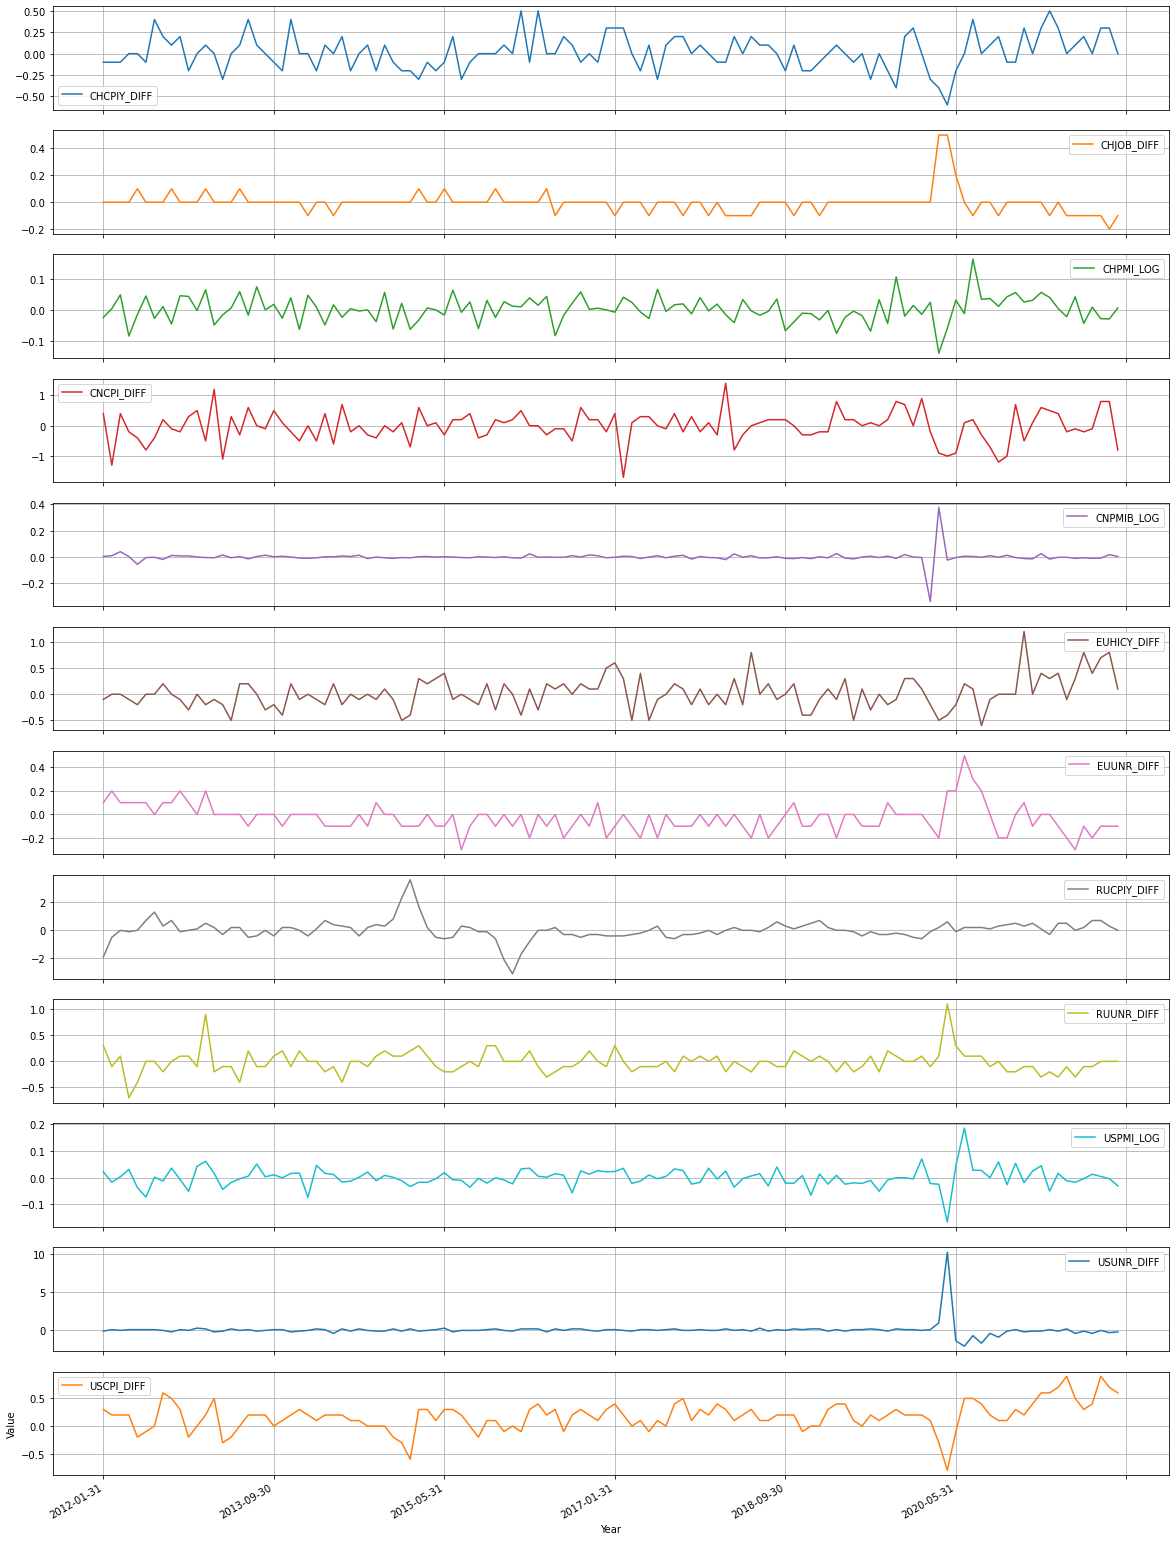

In [16]:
macro_clean_diff_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')
plt.savefig('Grafiken\Makro diff Line-Charts', dpi=800)

Futures Data:

In [17]:
futures_raw_close_pivot.describe()

Instrument,CLc1,Cc1,GCc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,65.972727,450.522727,1423.401653,124.804132,54.198926,3.064397,135.726860,1150.738430,1112.007438,20.117595,565.995868
std,22.254328,133.158282,240.907383,16.507157,33.657163,0.807724,25.664986,647.639804,261.222126,5.440663,121.885628
min,18.840000,301.500000,1060.300000,90.000000,9.630000,1.640000,94.800000,495.600000,724.400000,13.775000,361.000000
25%,48.520000,358.750000,1240.700000,113.450000,39.500000,2.575000,118.650000,703.000000,908.100000,16.124000,477.000000
50%,60.140000,384.500000,1316.200000,122.075000,49.810000,2.906000,132.950000,819.850000,1001.300000,18.014000,529.750000
75%,88.060000,534.000000,1660.600000,132.925000,60.680000,3.560000,148.350000,1532.000000,1371.100000,23.463000,655.000000
max,107.650000,806.500000,1967.600000,169.500000,251.180000,5.867000,221.950000,2957.700000,1691.100000,34.583000,902.500000


In [18]:
futures_raw_return_pivot.describe()

Instrument,CLc1,Cc1,GCc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,-0.002276,-0.000716,0.001288,0.001020,0.009540,0.001846,-0.001202,0.008903,-0.003104,-0.001484,0.001385
std,0.130546,0.082590,0.042386,0.056496,0.167224,0.121714,0.096164,0.083052,0.062873,0.078962,0.078908
min,-0.781866,-0.308383,-0.129212,-0.163827,-0.414303,-0.450252,-0.234889,-0.260308,-0.174839,-0.193546,-0.208109
25%,-0.057495,-0.037740,-0.025365,-0.026490,-0.074080,-0.058933,-0.060380,-0.031754,-0.043480,-0.053909,-0.056672
50%,0.008843,-0.001432,-0.000174,-0.000086,0.004009,-0.002149,-0.000861,0.024872,-0.004869,-0.009814,0.003019
75%,0.060140,0.038369,0.030713,0.034382,0.074449,0.067967,0.052485,0.056742,0.044977,0.040002,0.043571
max,0.633269,0.271153,0.104223,0.140179,0.676408,0.379753,0.243494,0.222933,0.132332,0.265913,0.253699


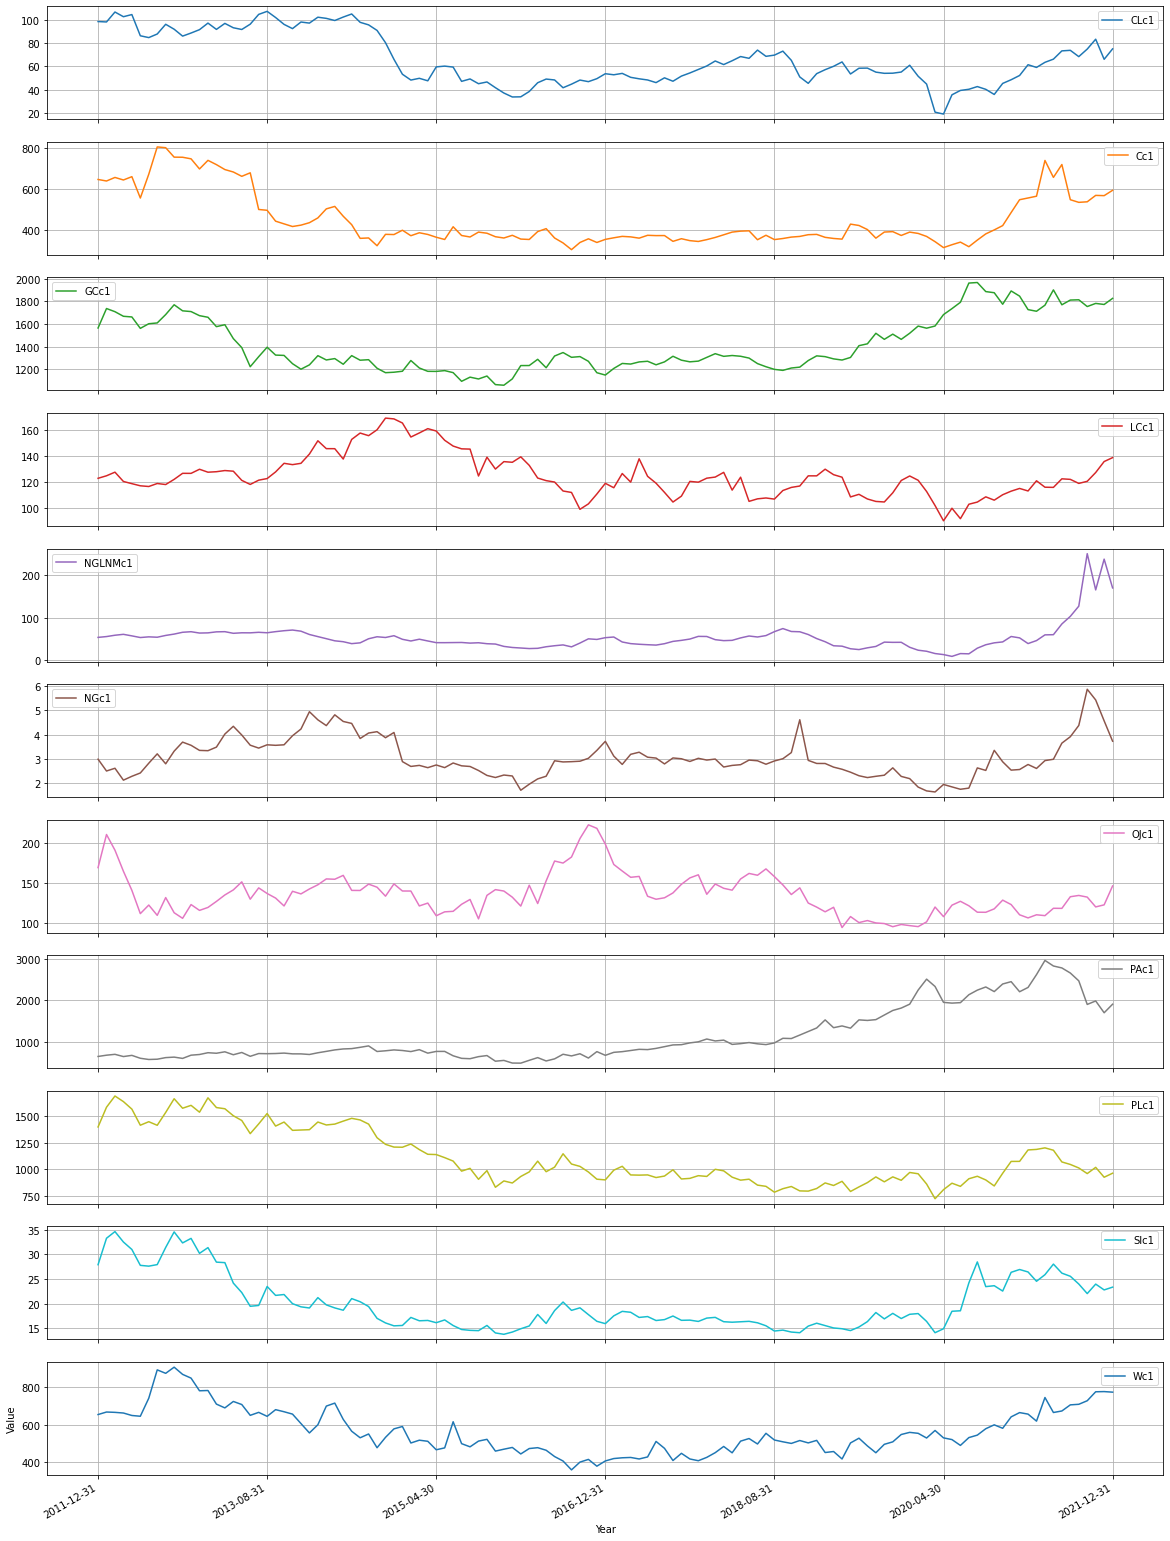

In [20]:
futures_raw_close_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')
plt.savefig('Grafiken\Futures Close Line-Charts', dpi=800)

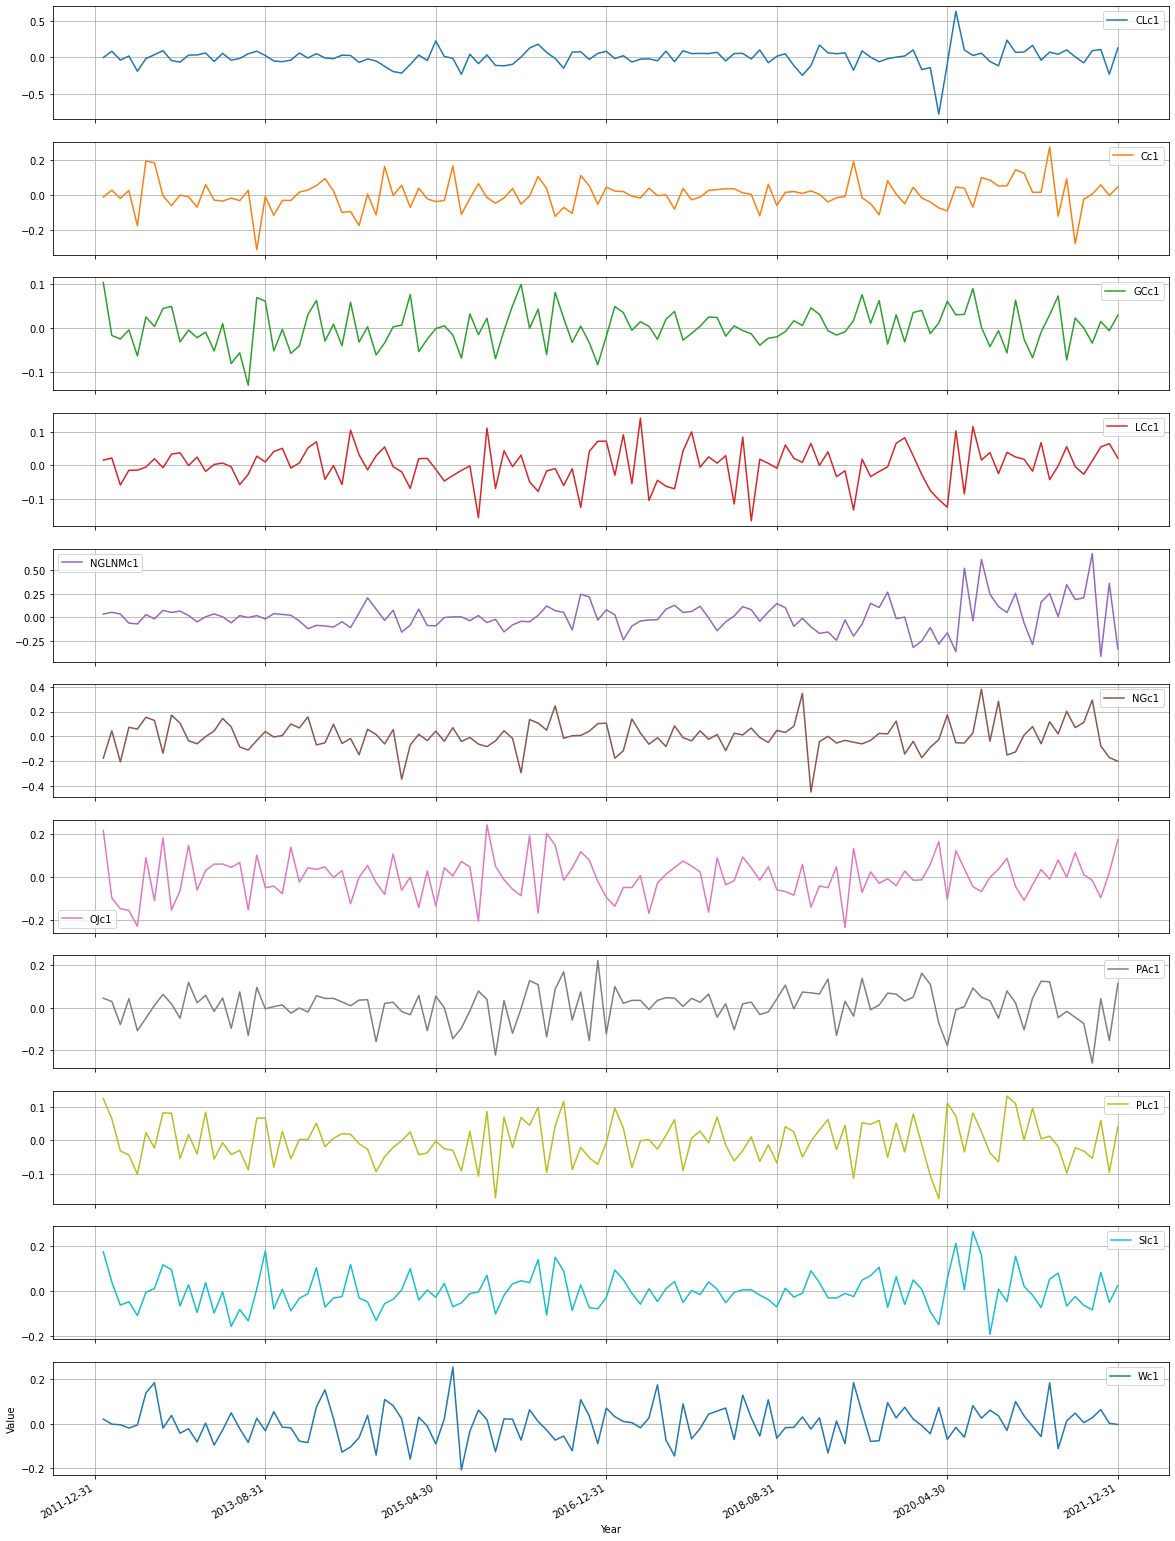

In [21]:
futures_raw_return_pivot.plot(kind = 'line',
                           legend = True,
                           subplots=True,
                           grid = True,
                           figsize = (20,30)
                           )
plt.ylabel('Value')
plt.xlabel('Year')
plt.savefig('Grafiken\Futures Return Line-Charts', dpi=800)

In [22]:
futures_raw_close_pivot.isna().sum()

Instrument
CLc1       0
Cc1        0
GCc1       0
LCc1       0
NGLNMc1    0
NGc1       0
OJc1       0
PAc1       0
PLc1       0
SIc1       0
Wc1        0
dtype: int64

Transform the cleaned Difference Macro Table back into a 3-Column Structure to import it more easy into SQL DB:

In [23]:
macro_clean_diff = macro_clean_diff_pivot.unstack()
macro_clean_diff = pd.DataFrame(macro_clean_diff)
macro_clean_diff = macro_clean_diff.reset_index()
macro_clean_diff = macro_clean_diff.set_index('DATE')
macro_clean_diff = macro_clean_diff.rename(columns={'level_0': 'Indicator', 0:'Value_diff'})
macro_clean_diff

,Indicator,Value_diff
DATE,,
2012-01-31,CHCPIY_DIFF,-0.1
2012-02-29,CHCPIY_DIFF,-0.1
2012-03-31,CHCPIY_DIFF,-0.1
2012-04-30,CHCPIY_DIFF,0.0
2012-05-31,CHCPIY_DIFF,0.0
...,...,...
2021-08-31,USCPI_DIFF,0.3
2021-09-30,USCPI_DIFF,0.4
2021-10-31,USCPI_DIFF,0.9


In [24]:
#Futures Raw was all good. Drop the first Period, where Returns are empty:
futures_clean_return_pivot = futures_raw_return_pivot.dropna()
futures_clean_return_pivot

futures_clean = futures_raw.dropna()
futures_clean

,CLOSE,Instrument,Return
DATE,,,
2012-01-31,98.48,CLc1,-0.003548
2012-02-29,107.07,CLc1,0.083629
2012-03-31,103.02,CLc1,-0.038560
2012-04-30,104.87,CLc1,0.017798
2012-05-31,86.53,CLc1,-0.192230
...,...,...,...
2021-08-31,706.75,Wc1,0.004254
2021-09-30,725.50,Wc1,0.026184
2021-10-31,772.75,Wc1,0.063095


Save cleaned Data in SQL:

In [25]:
futures_clean = futures_clean.reset_index()
liste_SQL_futures_clean = futures_clean.values.tolist()
futures_clean

macro_clean_abs = macro_clean_abs.reset_index()
liste_SQL_macro_clean_abs = macro_clean_abs.values.tolist()
macro_clean_abs

macro_clean_diff = macro_clean_diff.reset_index()
liste_SQL_macro_clean_diff = macro_clean_diff.values.tolist()
macro_clean_diff

,DATE,Indicator,Value_diff
0,2012-01-31,CHCPIY_DIFF,-0.1
1,2012-02-29,CHCPIY_DIFF,-0.1
2,2012-03-31,CHCPIY_DIFF,-0.1
3,2012-04-30,CHCPIY_DIFF,0.0
4,2012-05-31,CHCPIY_DIFF,0.0
...,...,...,...
1435,2021-08-31,USCPI_DIFF,0.3
1436,2021-09-30,USCPI_DIFF,0.4
1437,2021-10-31,USCPI_DIFF,0.9
1438,2021-11-30,USCPI_DIFF,0.7


In [26]:
macro_clean_diff

,DATE,Indicator,Value_diff
0,2012-01-31,CHCPIY_DIFF,-0.1
1,2012-02-29,CHCPIY_DIFF,-0.1
2,2012-03-31,CHCPIY_DIFF,-0.1
3,2012-04-30,CHCPIY_DIFF,0.0
4,2012-05-31,CHCPIY_DIFF,0.0
...,...,...,...
1435,2021-08-31,USCPI_DIFF,0.3
1436,2021-09-30,USCPI_DIFF,0.4
1437,2021-10-31,USCPI_DIFF,0.9
1438,2021-11-30,USCPI_DIFF,0.7


In [27]:
macro_clean_abs

,DATE,Macro_Variable,Value
0,2011-12-31,USUNR_ECI,8.5
1,2012-01-31,USUNR_ECI,8.3
2,2012-02-29,USUNR_ECI,8.3
3,2012-03-31,USUNR_ECI,8.2
4,2012-04-30,USUNR_ECI,8.2
...,...,...,...
1447,2021-08-31,RUCPIY_ECI,6.7
1448,2021-09-30,RUCPIY_ECI,7.4
1449,2021-10-31,RUCPIY_ECI,8.1
1450,2021-11-30,RUCPIY_ECI,8.4


In [28]:
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute('''DROP TABLE IF EXISTS MACRO_CLEAN_ABS;''')
c.execute('''DROP TABLE IF EXISTS MACRO_CLEAN_DIFF;''')
c.execute('''DROP TABLE IF EXISTS FUTURES_CLEAN;''')

In [29]:
c.execute('''CREATE TABLE MACRO_CLEAN_ABS (
    "Macro_Variable" TEXT,
    DATE DATETIME,
	"Value" NUMERIC
);''')

c.execute('''CREATE TABLE MACRO_CLEAN_DIFF (
    DATE DATETIME,
    "Indicator" TEXT,
	"Value_diff" NUMERIC
);''')

c.execute('''CREATE TABLE FUTURES_CLEAN (
    DATE DATETIME,
	"CLOSE" NUMERIC,
    "Instrument" TEXT,
    "Return" NUMERIC
);''')


In [30]:
conn = sqlite3.connect(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")
c = conn.cursor()
c.executemany("INSERT INTO MACRO_CLEAN_ABS(DATE, Macro_Variable, Value) VALUES (?,?,?)", liste_SQL_macro_clean_abs)    
conn.commit()

c.executemany("INSERT INTO MACRO_CLEAN_DIFF(DATE, Indicator, Value_diff) VALUES (?,?,?)", liste_SQL_macro_clean_diff)    
conn.commit()

c.executemany("INSERT INTO FUTURES_CLEAN(DATE, CLOSE, Instrument, Return) VALUES (?,?,?,?)", liste_SQL_futures_clean)    
conn.commit()

In [31]:
#Select Statement to import the SQL Data back into Python:   
c = conn.cursor()
c.execute("SELECT DATE, Indicator, Value_diff FROM MACRO_CLEAN_DIFF")
macro_sql_data=c.fetchall()
macro_clean_sql = pd.DataFrame(macro_sql_data,columns=['DATE', 'Indicator', 'Value_diff'])
macro_clean_sql = macro_clean_sql.set_index('DATE')
macro_clean_sql

#Select Futures Data from SQL DB:   
c.execute("SELECT * FROM FUTURES_CLEAN")
futures_sql_data=c.fetchall()
futures_clean_sql = pd.DataFrame(futures_sql_data,columns=['DATE', 'CLOSE', 'Instrument', 'Return'])
futures_clean_sql = futures_clean_sql.set_index('DATE')
futures_clean_sql

,CLOSE,Instrument,Return
DATE,,,
2012-01-31,98.48,CLc1,-0.003548
2012-02-29,107.07,CLc1,0.083629
2012-03-31,103.02,CLc1,-0.038560
2012-04-30,104.87,CLc1,0.017798
2012-05-31,86.53,CLc1,-0.192230
...,...,...,...
2021-08-31,706.75,Wc1,0.004254
2021-09-30,725.50,Wc1,0.026184
2021-10-31,772.75,Wc1,0.063095


In [32]:
macro_clean_abs_pivot.to_excel('Files\Macro_clean_abs_pivot.xlsx')
macro_clean_diff_pivot.to_excel('Files\Macro_clean_diff_pivot.xlsx')
futures_raw_close_pivot.to_excel('Files\Futures_clean_CLOSE_pivot.xlsx')
futures_clean_return_pivot.to_excel('Files\Futures_clean_returns_pivot.xlsx')